## Ground Truth Generation Notebook.

This notebook generates a pre configured number of molecules and shows their alignments

In [13]:
Molecule = 3 #Pick molecule Number between 0 and 512

### Imports 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy
from scipy.interpolate import interp1d
from deepom.bionano_utils import MoleculeSelector

from deepom.config import Config
from deepom.localizer import LocalizerModule
import monai

from deepom.aligner import Aligner
from deepom.my_utils import get_aligner, overlap_percentage, get_scaler_from_aligner
import numpy as np

from deepom.bionano_compare import BionanoCompare
from matplotlib.pyplot import eventplot, imshow, figure, xlim




### selector Creation

In [2]:
#Need To check about Caching
selector = MoleculeSelector()
selector.top_mol_num = 50
selector.select_molecules()

selected: 0it [00:00, ?it/s]

### Refs

In [6]:
compare = BionanoCompare()
compare.read_cmap()
compare.make_refs()
compare.refs

1     [14453.0, 19686.0, 22554.0, 31191.0, 33547.0, ...
2     [15924.0, 22064.0, 28594.0, 34027.0, 34664.0, ...
3     [12734.0, 13105.0, 17438.0, 20151.0, 26344.0, ...
4     [12985.0, 14575.0, 23028.0, 27375.0, 35689.0, ...
5     [19314.0, 19924.0, 22572.0, 48655.0, 52154.0, ...
6     [76216.0, 78491.0, 80268.0, 84078.0, 92283.0, ...
7     [10487.0, 12916.0, 15501.0, 17193.0, 18142.0, ...
8     [61805.0, 66488.0, 70256.0, 73189.0, 79269.0, ...
9     [14566.0, 19799.0, 22667.0, 30973.0, 33330.0, ...
10    [18514.0, 19074.0, 29291.0, 29794.0, 32222.0, ...
11    [60457.0, 62233.0, 66043.0, 73015.0, 81386.0, ...
12    [14568.0, 19721.0, 24617.0, 33245.0, 35595.0, ...
13    [16004725.0, 16010361.0, 16021642.0, 16136233....
14    [16004725.0, 16010361.0, 16021642.0, 16031132....
15    [17050953.0, 17052426.0, 17058646.0, 17060180....
16    [14134.0, 19375.0, 28229.0, 38092.0, 44607.0, ...
17    [66653.0, 70073.0, 84695.0, 84709.0, 90870.0, ...
18    [18868.0, 19428.0, 29621.0, 30124.0, 32552

### Localizer

In [9]:
localizer_module = LocalizerModule()
localizer_module.checkpoint_search_dir = Config.CHECKPOINT_SEARCH_DIR
localizer_module.load_checkpoint = True
localizer_module.init_ensure_module()

image_input = selector.selected[Molecule].bionano_image.segment_image[0]
target_width = localizer_module.image_channels
source_width = image_input.shape[0] // 2 + 1
image_input = image_input[source_width - target_width // 2: source_width + target_width // 2 + 1]
inference_item = localizer_module.inference_item(image_input)

BasicUNet features: (32, 32, 64, 128, 256, 32).
loading checkpoint:  /home/deepom/DeepOM/data/pretrained/checkpoint.pickle 




/home/deepom/miniconda3/envs/deepom/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [10]:
inference_item.image

array([[354.3285672 , 305.22658343, 373.50928024, ..., 354.64970765,
        335.52176031, 346.54458259],
       [372.38941847, 311.59678616, 374.9998085 , ..., 337.30409376,
        315.27417498, 361.80708801],
       [386.92272084, 342.79914934, 348.77550677, ..., 332.25024347,
        330.2285963 , 322.39442429],
       [367.31041054, 331.82490011, 337.93338048, ..., 328.79456173,
        346.93258554, 328.31157526],
       [323.41750921, 313.89068901, 321.19127113, ..., 318.52962071,
        346.92212118, 330.83735662]])

In [11]:
inference_item.image_input

tensor([[0.0692, 0.0190, 0.0889,  ..., 0.0696, 0.0500, 0.0613],
        [0.0877, 0.0255, 0.0904,  ..., 0.0518, 0.0293, 0.0769],
        [0.1026, 0.0574, 0.0636,  ..., 0.0466, 0.0446, 0.0365],
        [0.0825, 0.0462, 0.0525,  ..., 0.0431, 0.0617, 0.0426],
        [0.0376, 0.0278, 0.0353,  ..., 0.0326, 0.0617, 0.0452]])
Metadata
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)
	space: RAS

Applied operations
[ {class: 'SpatialPad', extra_info: {'padded': [(0, 0), (0, 0), (0, 0)]}, id: 140339555741072, orig_size: (5, 1707)},
  {class: 'SpatialCrop', extra_info: {'cropped': [0, 0, 0, 0]}, id: 140339557787248, orig_size: (5, 1707)},
  {class: 'SpatialPad', extra_info: {'padded': [(0, 0), (0, 0)]}, id: 140339555738480, orig_size: (1707,)}]
Is batch?: False

### Alignment

In [6]:
ref_id = selector.selected[Molecule].xmap_item.ref_id

aligner_reg = get_aligner()
aligner_rev = get_aligner()

qry = inference_item.loc_pred * 335

inverted_qry = np.sort((inference_item.loc_pred[-1] - inference_item.loc_pred)*335) #not sure, need to make sure its correct

aligner_reg.make_alignment(qry=qry, ref=compare.refs[ref_id])
aligner_rev.make_alignment(qry=inverted_qry, ref=compare.refs[ref_id])

### Selecting the best orientation based on overlap percentage

In [7]:
regular_overlap = overlap_percentage(selector.selected[Molecule].xmap_item.ref_lims, aligner_reg.alignment_ref[[0, -1]])
reverse_overlap = overlap_percentage(selector.selected[Molecule].xmap_item.ref_lims, aligner_rev.alignment_ref[[0, -1]])

aligner = aligner_reg if regular_overlap > reverse_overlap else aligner_rev

regular_overlap*100, reverse_overlap*100

(0.0, 99.8317852841028)

In [8]:
scaler = get_scaler_from_aligner(aligner)

z = aligner.alignment_ref
y = (z-z[0]) / (scaler*335)
y = y+aligner.alignment_qry[0] /335
x = aligner.alignment_qry/335
func = interp1d(x=y,y=x)

ref = compare.refs[ref_id]
start, end = aligner.alignment_ref[[0, -1]]
start_index = np.argmax(ref >= start)
end_index = np.argmin(ref <= end)
ref_crop = ref[start_index:end_index]

z_hat = (ref_crop-ref_crop[0]) / (scaler*335)
z_hat = z_hat+x[0]
y_hat = func(z_hat)



### Plot

(0.0, 800.0)

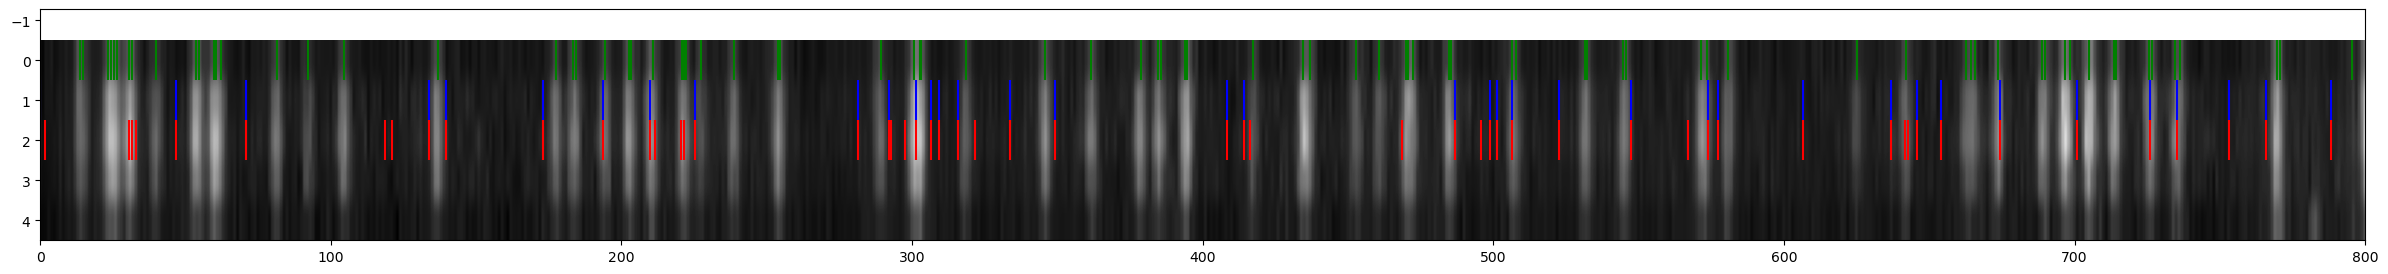

In [9]:
figure(figsize=(30, 3))
image_input = selector.selected[Molecule].bionano_image.segment_image[0]
target_width = localizer_module.image_channels
source_width = image_input.shape[0] // 2 + 1
image_input = image_input[source_width - target_width // 2: source_width + target_width // 2 + 1]
imshow(image_input, aspect="auto", cmap="gray")
eventplot([inference_item.loc_pred, x,y_hat], colors=["g", "b", "r"])
xlim([0, 800])

In [1]:
from deepom.data_fetcher import DataFetcher

data_fetcher = DataFetcher(num_molecules=5)
# data_fetcher.generate_ground_truth_plots()
mol,a,b = data_fetcher.generate_ground_truth(molecule_index=0)
a,b

BasicUNet features: (32, 32, 64, 128, 256, 32).
loading checkpoint:  /home/deepom/DeepOM/data/pretrained/checkpoint.pickle 




selected: 0it [00:00, ?it/s]

/home/deepom/miniconda3/envs/deepom/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(array([0, 0, 0, ..., 0, 0, 0]), array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]))

920.7166558160525

In [17]:
# import image module
from IPython.display import Image,display,plot_images
  
# get the image
for img_index in range(30):
    display(Image(url=f"../data/ground_truth/ground_truth_{img_index}.png"))
    
    

ImportError: cannot import name 'plot_images' from 'IPython.display' (/home/deepom/miniconda3/envs/deepom/lib/python3.9/site-packages/IPython/display.py)